In [1]:
from matteo_eval import user_inputs, extractIngredients, ground_truth
from white_list import white_list
from NER import extract_ingredients_NER
from preprocessing import *
from get_recipe_levenstein import levenstein_dist
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import json

In [2]:
with open('user_inputs.json', 'r') as file:
    user_inputs = json.load(file)

with open('user_inputs_ingredients.json', 'r') as file:
    ground_truth = json.load(file)

df = load_data("filtered_recipes.csv")
df = filter_tags(df,["beverages"])
df = df.iloc[len(user_inputs):]
df.reset_index(drop=True, inplace=True)

#user_inputs = user_inputs[:3]
#ground_truth = ground_truth[:3]

In [3]:
white_list_results = white_list(df, user_inputs)

In [14]:
ner_results = extract_ingredients_NER(user_inputs)
ner_results

[['give me',
  'squash',
  'mexican seasoning',
  'mixed spice',
  'honey',
  'butter',
  'olive oil',
  'salt'],
 ['prepared pizza',
  'crust',
  'sausage patty',
  'eggs',
  'milk',
  'pepper',
  'cheese'],
 ['sugar',
  'unsalted butter',
  'bananas',
  'eggs',
  'fresh',
  'juice',
  'orange rind',
  'cake flour',
  'baking soda',
  'salt'],
 ['wafers',
  'butter',
  'powdered sugar',
  'eggs',
  'whipping cream',
  'strawberry',
  'walnuts'],
 ['northern beans',
  'chicken bouillon',
  'brown sugar',
  'molasses',
  'cornstarch',
  'onion',
  'garlic powder',
  'mustard powder',
  'chili powder',
  'salt',
  'black pepper',
  'bacon',
  'water'],
 ['pork chops', 'flour', 'salt', 'mustard', 'garlic powder', 'oil', 'chicken'],
 ['wraps', 'whole green', 'chilies', 'cheese', 'cornstarch', 'oil'],
 ['butterscotch chips', 'noodles', 'salted peanuts'],
 ['water',
  'salt',
  'boiling potatoes',
  'fresh',
  'leaves',
  'unsalted butter',
  'coarse salt',
  'fresh',
  'ground black',
  'pe

In [5]:
llm_results = extractIngredients(user_inputs)

100%|██████████| 50/50 [1:05:48<00:00, 78.98s/it] 


In [5]:
import pickle
with open("llm_ingr_results.pkl", "rb") as f:
    llm_results = pickle.load(f)

In [6]:
llm_results_split = [list(map(lambda x: x.lower().strip(), llm_results[i].split(','))) for i in range(len(llm_results))]

In [7]:
def delete_before_last_newline(s):
    # CHATGPT
    # Find the position of the last newline character
    last_newline_pos = s.rfind('\n')
    
    # If a newline is found, return the substring after it
    if last_newline_pos != -1:
        return s[last_newline_pos + 1:]
    else:
        # If no newline is found, return the original string
        return s

In [8]:
llm_results_clean = []
for s in llm_results_split:
    s_clean = [delete_before_last_newline(ss) for ss in s]
    llm_results_clean.append(s_clean)


In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD


def preprocess(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    return text


# only transform the user’s ingredients into a vector and compare that to the vectors of the recipes
# ids = ids to exclude from df
def cosine_simi(user_ingredients, truth):

    # Preprocess user input ingredients
    user_ingredients = [preprocess(ingredient) for ingredient in user_ingredients]
    user_ingredients_str = ' '.join(user_ingredients)

    truth_ingredients = [preprocess(ingredient) for ingredient in truth]
    truth_ingredients_str = ' '.join(truth_ingredients)
    

    # Create the TfidfVectorizer instance
    with open("vect.pkl", "rb") as f:
        vectorizer = pickle.load(f)
    truth_ingredients_vect =vectorizer.transform([truth_ingredients_str])
    user_ingredients_vect = vectorizer.transform([user_ingredients_str])
    # Dimensionality reduction
    with open("svd.pkl", "rb") as f:
        svd = pickle.load(f)
    truth_svd = svd.transform(truth_ingredients_vect)
    user_svd = svd.transform(user_ingredients_vect)

    # Compute cosine similarity
    cosine_sim = cosine_similarity(user_svd, truth_svd).flatten()[0]
    return cosine_sim

In [55]:
ingredients_lists = [white_list_results, ner_results, llm_results_clean]
methods = ["white_list", "ner", "llm"]
cosine_results = {"white_list":[], "ner":[], "llm":[]}

for i,ingredients_list in enumerate(ingredients_lists):
    for j,ingredients in enumerate(ingredients_list):
        dist = cosine_simi(ingredients,ground_truth[j])
        cosine_results[methods[i]].append(dist)

In [63]:

# CHATGPT GENERATED FUNCTION
def generate_violin_plot(data_dict):
    # Convert dictionary to a format suitable for seaborn
    data = []
    for method, measurements in data_dict.items():
        for measurement in measurements:
            data.append({'Method': method, 'Measurement': measurement})

    # Create a DataFrame from the data
    df = pd.DataFrame(data)

    # Set larger font sizes
    sns.set_context("notebook", font_scale=1.5)

    # Create the violin plot using seaborn
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='Method', y='Measurement', data=df, inner='quartile',  palette= sns.color_palette())
    plt.ylim(0.2,1)
    plt.title('Ingredients extraction method comparison')
    plt.xlabel('Method')
    plt.ylabel('Cosine Similarity')
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.show()



<Axes: ylabel='Count'>

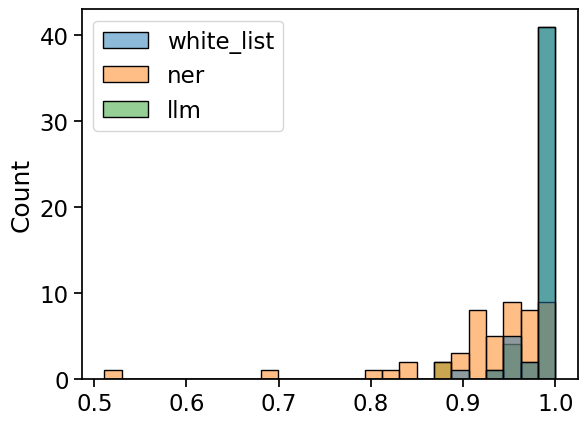

In [64]:
sns.histplot(data= pd.DataFrame(cosine_results))

C:\Users\teobo\AppData\Local\Temp\ipykernel_18404\3542489749.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='Measurement', data=df, inner='quartile',  palette= sns.color_palette())
C:\Users\teobo\AppData\Local\Temp\ipykernel_18404\3542489749.py:17: UserWarning: The palette list has more values (10) than needed (3), which may not be intended.
  sns.violinplot(x='Method', y='Measurement', data=df, inner='quartile',  palette= sns.color_palette())


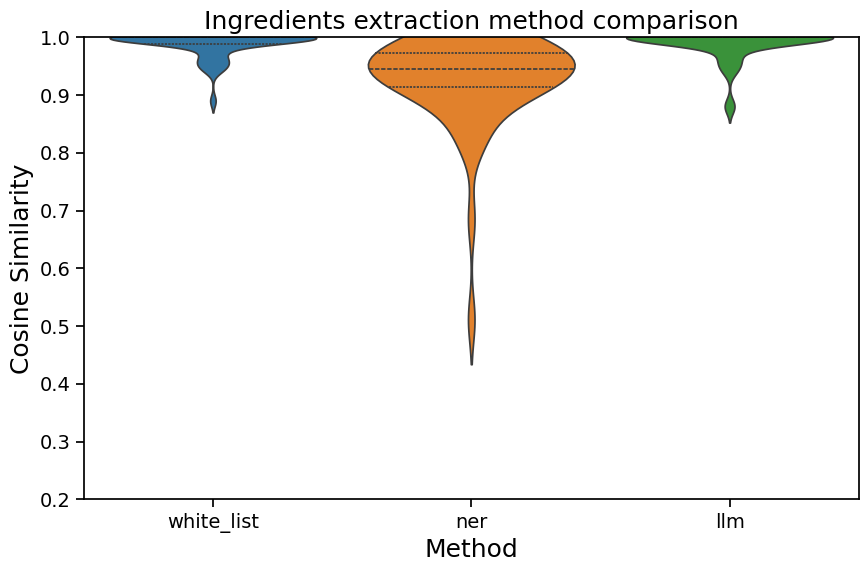

In [65]:
generate_violin_plot(cosine_results)
